# Smv Exercise 1: Employment Data

In [1]:
# Import necessary packages
import smv
import pandas as pd
from pyspark.sql import HiveContext, DataFrame

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Read the input data from a csv file
raw = openCsv("data/input/employment/CB1200CZ11.csv")

In [2]:
raw_clean = raw.where(col("EMP_F").isNull()).cache()
df1 = raw_clean. \
smvSelectPlus(substring_index(substring_index(col("GEO_TTL"), ",", -1),")", 1).alias("ST_CD")). \
where(length(col("ST_CD"))<3).cache()

### Q1: What are the distributions of ESTAB, EMP and PAYANN for state Illinois?

In [3]:
df1.filter(col("ST_CD")=="IL").smvEdd("ESTAB", "EMP", "PAYANN")

ESTAB                Non-Null Count         1161
ESTAB                Null Count             0
ESTAB                Average                265.69853574504737
ESTAB                Standard Deviation     428.20525058336733
ESTAB                Min                    3.0
ESTAB                Max                    3293.0
EMP                  Non-Null Count         1161
EMP                  Null Count             0
EMP                  Average                4216.646856158484
EMP                  Standard Deviation     8844.549907127255
EMP                  Min                    2.0
EMP                  Max                    132982.0
PAYANN               Non-Null Count         1161
PAYANN               Null Count             0
PAYANN               Average                207975.86735572782
PAYANN               Standard Deviation     636282.6451741568
PAYANN               Min                    61.0
PAYANN               Max                    1.286426E7


### Q2: Draw a histogram with 20 bins of payroll per employee for state California

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ff6d9b490>]], dtype=object)

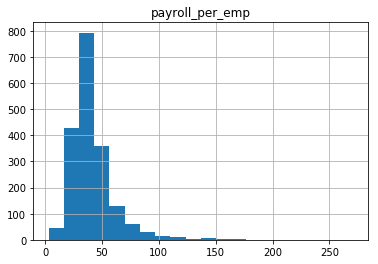

In [4]:
df1.filter(col("ST_CD")=="CA").select((col("PAYANN")/col("EMP")).alias("payroll_per_emp")).toPandas().hist(bins=20)

### Q3: What are the top 5 states with the highest average employees per establishment?

In [5]:
df1.groupBy("ST_CD").agg(
    avg(col("EMP").cast("float")/col("ESTAB").cast("float")).alias("avg_emp_per_estab"),
    max(lit("US")).alias("country")
).smvGroupBy("country").smvTopNRecs(5, col("avg_emp_per_estab").desc()).toPandas().head(5)

,ST_CD,avg_emp_per_estab,country
0,DC,17.125650,US
1,CT,15.994080,US
2,SC,14.041804,US
3,UT,14.026347,US
4,NV,13.833006,US


### Q4: What is the difference # of employees for each state if we don't do the data preprocessing to filter out observations with suppression?

In [6]:
state_avg1 = raw.groupBy("ST").agg(
    avg("EMP").alias("avg1_EMP")
)

state_avg2 = raw_clean.groupBy("ST").agg(
    avg("EMP").alias("avg2_EMP")
)

state_compare = state_avg2.smvJoinByKey(state_avg1, ["ST"], "inner").\
    smvSelectPlus((col("avg2_EMP") - col("avg1_EMP")).alias("avg_diff"))
    
state_compare.smvBinHist(("avg_diff",50))

Histogram of avg_diff: with BIN size 50.0
key                      count      Pct    cumCount   cumPct
0.0                          1    1.92%           1    1.92%
200.0                        1    1.92%           2    3.85%
300.0                        1    1.92%           3    5.77%
350.0                        2    3.85%           5    9.62%
400.0                        3    5.77%           8   15.38%
450.0                        3    5.77%          11   21.15%
500.0                        5    9.62%          16   30.77%
550.0                        2    3.85%          18   34.62%
600.0                        3    5.77%          21   40.38%
650.0                        3    5.77%          24   46.15%
700.0                        3    5.77%          27   51.92%
750.0                        3    5.77%          30   57.69%
800.0                        3    5.77%          33   63.46%
850.0                        2    3.85%          35   67.31%
900.0                        4    7.69%    

### Q5: At state level, what is the covariance between average # of employees per establishment and average payroll per employee?

In [7]:
df1.groupBy("ST_CD").agg(
    avg(col("EMP").cast("float")/col("ESTAB").cast("float")).alias("avg_emp_per_estab"),
    avg(col("PAYANN").cast("float")/col("EMP").cast("float")).alias("avg_payroll_per_emp")    
).cov("avg_emp_per_estab", "avg_payroll_per_emp")

5.453275069645748